In [139]:
import time
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import csv
import pickle
import numpy as np
import pandas as pd
import pickle
import jdatetime
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import arabic_reshaper
import geopandas
import geopandas as gpd
#starting date = 29 tir

In [61]:
df = pd.read_csv("job.csv")

C:\Users\Arian_Gh\AppData\Local\Temp\ipykernel_19400\1541966218.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("job.csv")


In [62]:
df.head()

,company_size,education,gender,salary,workdays,language,business_trip,industry,bonus,location,ad_name,softwares,military_services,experience,date,min_age,max_age
0,30,['کارشناسی| مالی و حسابداری'],ترجیحاً خانم,NaN,شنبه تا چهارشنبه 8 الی 16,['انگلیسی| متوسط ۵۰٪'],-,نفت، گاز و پتروشیمی,-,تهران، فاطمی,کارشناس حسابداری,"['Microsoft Word| متوسط', 'Microsoft Excel| مت...",NaN,NaN,1402-03-23,23.0,33.0
1,125,NaN,فقط آقا,12 - 10 میلیون تومان,شنبه تا چهارشنبه 8 تا 17:33، پنجشنبه 8:30 تا ...,NaN,-,تولیدی / صنعتی,پاداش -بیمه درمان تکمیلی,رباط کریم,کارگر ساده - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-26,23.0,45.0
2,5000+,NaN,تفاوتی ندارد,NaN,شنبه تا چهارشنبه 7 الی 16,NaN,-,بانکداری,وام -پاداش -بیمه درمان تکمیلی -تسهیلات تفری...,تهران، آرژانتین,کارشناس موشن گرافیست,"['Adobe Photoshop| پیشرفته', 'Adobe Illustrato...",اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-11,NaN,35.0
3,30,NaN,تفاوتی ندارد,20 - 15 میلیون تومان,10 تا 20,['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,پورسانت,تهران، جردن,مدیر اجرایی,"['Microsoft Word| متوسط', 'Microsoft Powerpoin...",NaN,NaN,1402-02-12,25.0,43.0
4,750,NaN,فقط آقا,NaN,شیفت شب ( 3 روز در هفته ),['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,بیمه درمان تکمیلی -اتاق بازی -ناهار -میان و...,کرج، حیدرآباد,کارشناس مرکز تماس ( شیفت شب) - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-04-06,20.0,30.0


In [63]:
def convert_salary(salary_str):
    if pd.isna(salary_str):
        return np.nan
    
    # Handle both versions of the "million toman" string in Persian
    s_cleaned = salary_str.replace(' میلیون تومان', '').replace(' ميليون تومان', '').replace(' Million Tomans', '')
    
    # Handle "Above 60" and "60 به بالا" cases
    if "Above" in s_cleaned:
        s_cleaned = s_cleaned.replace('Above ', '') + '-70'
    elif "به بالا" in s_cleaned:
        s_cleaned = s_cleaned.replace(' به بالا', '') + '-70'
    
    try:
        salaries = [float(s.strip()) for s in s_cleaned.split("-")]
        return sum(salaries)/len(salaries)
    except ValueError:
        # Print the problematic string for debugging
        print(f"Problematic string: {s_cleaned}")
        return np.nan

df['avg_salary'] = df['salary'].apply(convert_salary)

In [64]:
del df["salary"]

In [65]:
df.head()

,company_size,education,gender,workdays,language,business_trip,industry,bonus,location,ad_name,softwares,military_services,experience,date,min_age,max_age,avg_salary
0,30,['کارشناسی| مالی و حسابداری'],ترجیحاً خانم,شنبه تا چهارشنبه 8 الی 16,['انگلیسی| متوسط ۵۰٪'],-,نفت، گاز و پتروشیمی,-,تهران، فاطمی,کارشناس حسابداری,"['Microsoft Word| متوسط', 'Microsoft Excel| مت...",NaN,NaN,1402-03-23,23.0,33.0,NaN
1,125,NaN,فقط آقا,شنبه تا چهارشنبه 8 تا 17:33، پنجشنبه 8:30 تا ...,NaN,-,تولیدی / صنعتی,پاداش -بیمه درمان تکمیلی,رباط کریم,کارگر ساده - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-26,23.0,45.0,11.0
2,5000+,NaN,تفاوتی ندارد,شنبه تا چهارشنبه 7 الی 16,NaN,-,بانکداری,وام -پاداش -بیمه درمان تکمیلی -تسهیلات تفری...,تهران، آرژانتین,کارشناس موشن گرافیست,"['Adobe Photoshop| پیشرفته', 'Adobe Illustrato...",اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-11,NaN,35.0,NaN
3,30,NaN,تفاوتی ندارد,10 تا 20,['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,پورسانت,تهران، جردن,مدیر اجرایی,"['Microsoft Word| متوسط', 'Microsoft Powerpoin...",NaN,NaN,1402-02-12,25.0,43.0,17.5
4,750,NaN,فقط آقا,شیفت شب ( 3 روز در هفته ),['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,بیمه درمان تکمیلی -اتاق بازی -ناهار -میان و...,کرج، حیدرآباد,کارشناس مرکز تماس ( شیفت شب) - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-04-06,20.0,30.0,NaN


In [66]:
df_location = df.copy()

In [67]:
df_location["location"] = df_location["location"].apply(lambda x: str(x).split("،")[0] if x != "nan" else x)

In [68]:
df_location["location"] = df_location["location"].apply(lambda x: str(x).replace("امکان دورکاری",""))
df_location["location"] = df_location["location"].apply(lambda x: str(x).replace("امکان استخدام معلولین",""))
df_location["location"] = df_location["location"].apply(lambda x: str(x).replace("امکان جذب کارآموز",""))
df_location["location"] = df_location["location"].apply(lambda x: x.strip())

In [69]:
df_location["location"].value_counts()

location
تهران                                    19400
اصفهان                                    1198
کرج                                       1067
مشهد                                       966
nan                                        603
                                         ...  
Alborz Industrial City                       1
سعادت آباد                                   1
Tehran/ Abas Abad(Beheshti)Internship        1
Tehran/ Gheytariyeh                          1
امیرکلا                                      1
Name: count, Length: 756, dtype: int64

In [70]:
import re
pattern = r'[a-zA-Z]'

# Apply the regex pattern to the 'ad_name' column and create a new column 'is_english'
df_location['is_english'] = df_location['gender'].apply(lambda x: bool(re.search(pattern, str(x))))

# Filter the DataFrame to only include English job ads
df_location = df_location[df_location['is_english']==False]

In [116]:
df2 = df_location.copy()
df2 = df2.reset_index(drop=True)
df2.head()

,company_size,education,gender,workdays,language,business_trip,industry,bonus,location,ad_name,softwares,military_services,experience,date,min_age,max_age,avg_salary,is_english
0,30,['کارشناسی| مالی و حسابداری'],ترجیحاً خانم,شنبه تا چهارشنبه 8 الی 16,['انگلیسی| متوسط ۵۰٪'],-,نفت، گاز و پتروشیمی,-,تهران,کارشناس حسابداری,"['Microsoft Word| متوسط', 'Microsoft Excel| مت...",NaN,NaN,1402-03-23,23.0,33.0,NaN,False
1,125,NaN,فقط آقا,شنبه تا چهارشنبه 8 تا 17:33، پنجشنبه 8:30 تا ...,NaN,-,تولیدی / صنعتی,پاداش -بیمه درمان تکمیلی,رباط کریم,کارگر ساده - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-26,23.0,45.0,11.0,False
2,5000+,NaN,تفاوتی ندارد,شنبه تا چهارشنبه 7 الی 16,NaN,-,بانکداری,وام -پاداش -بیمه درمان تکمیلی -تسهیلات تفری...,تهران,کارشناس موشن گرافیست,"['Adobe Photoshop| پیشرفته', 'Adobe Illustrato...",اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-11,NaN,35.0,NaN,False
3,30,NaN,تفاوتی ندارد,10 تا 20,['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,پورسانت,تهران,مدیر اجرایی,"['Microsoft Word| متوسط', 'Microsoft Powerpoin...",NaN,NaN,1402-02-12,25.0,43.0,17.5,False
4,750,NaN,فقط آقا,شیفت شب ( 3 روز در هفته ),['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,بیمه درمان تکمیلی -اتاق بازی -ناهار -میان و...,کرج,کارشناس مرکز تماس ( شیفت شب) - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-04-06,20.0,30.0,NaN,False


In [117]:
df2["location"] = df2["location"].apply(lambda x: str(x).replace("پل‏دشت","problem"))
df2= df2[df2["location"]!="problem"]

In [118]:
location_mapping ={
    'تهران': 'تهران',
    'اصفهان': 'اصفهان',
    'کرج': 'البرز',
    'مشهد': 'خراسان رضوی',
    'شیراز': 'فارس',
    'قم': 'قم',
    'تبریز': 'آذربایجان شرقی',
    'قزوین': 'قزوین',
    'شهر قدس': 'تهران',
    'رشت': 'گیلان',
    'اهواز': 'خوزستان',
    'یزد': 'یزد',
    'ساوه': 'مرکزی',
    'پردیس': 'تهران',
    'ساری': 'مازندران',
    'شهریار': 'تهران',
    'صفادشت': 'تهران',
    'هشتگرد': 'البرز',
    'کرمان': 'کرمان',
    'رباط کریم': 'تهران',
    'پاکدشت': 'تهران',
    'بندرعباس': 'هرمزگان',
    'پرند': 'تهران',
    'اشتهارد': 'البرز',
    'آمل': 'مازندران',
    'اسلام شهر': 'تهران',
    'اراک': 'مرکزی',
    'گرگان': 'گلستان',
    'کهریزک': 'تهران',
    'زنجان': 'زنجان',
    'همدان': 'همدان',
    'بابل': 'مازندران',
    'ارومیه': 'آذربایجان غربی',
    'احمدآباد مستوفی': 'البرز',
    'کرمانشاه': 'کرمانشاه',
    'نظر آباد': 'البرز',
    'گرمدره': 'مازندران',
    'اردبیل': 'اردبیل',
    'سمنان': 'سمنان',
    'چهاردانگه': 'تهران',
    'فردیس کرج': 'البرز',
    'ری': 'تهران',
    'بوشهر': 'بوشهر',
    'بیرجند': 'خراسان جنوبی',
    'زاهدان': 'سیستان و بلوچستان',
    'خرم آباد': 'لرستان',
    'سنندج': 'کردستان',
    'تاکستان': 'قزوین',
    'بجنورد': 'خراسان شمالی',
    'ابیک': 'قزوین',
    'کیش': 'هرمزگان',
    'زرندیه': 'مرکزی',
    'کمالشهر': 'البرز',
    'کاشان': 'اصفهان',
    'نجف آباد': 'اصفهان',
    'شاهین شهر (میمه)': 'اصفهان',
    'حسن اباد': 'هرمزگان',
    'بندرانزلی': 'گیلان',
    'بهارستان': 'تهران',
    'قائم شهر': 'مازندران',
    'شمیرانات': 'تهران',
    'جاجرود': 'تهران',
    'آبادان': 'خوزستان',
    'بویر احمد(یاسوج)': 'کهگیلویه و بویراحمد',
    'دزفول': 'خوزستان',
    'ایوانکی': 'سمنان',
    'باقر شهر': 'تهران',
    'عسلویه': 'بوشهر',
    'چابهار': 'سیستان و بلوچستان',
    'ایلام': 'ایلام',
    'سیرجان': 'کرمان',
    'نیشابور': 'خراسان رضوی',
    'ساوجبلاغ': 'البرز',
    'محمود آباد': 'مازندران',
    'بابلسر': 'مازندران',
    'باوی': 'خوزستان',
    'آستارا': 'گیلان',
    'جلفا': 'آذربایجان شرقی',
    'میاندورود': 'مازندران',
    'بجستان': 'خراسان رضوی',
    'مهران': 'ایلام',
    'جویبار': 'مازندران',
    'زابل': 'سیستان و بلوچستان',
    'نی ریز': 'فارس',
    'سبزوار': 'خراسان رضوی',
    'شاهرود': 'سمنان',
    'دورود': 'لرستان',
    'ماروند': 'آذربایجان غربی',
    'ماکو': 'آذربایجان غربی',
    'تفریش': 'مرکزی',
    'مهاباد': 'آذربایجان غربی',
    'نور': 'مازندران',
    'خواف': 'خراسان رضوی',
    'خوی': 'آذربایجان غربی',
    'بافت': 'کرمان',
    'کنارک': 'سیستان و بلوچستان',
    'دلیجان': 'مرکزی',
    'ازنا': 'لرستان',
    'ملایر': 'همدان',
    'بندر لنگه': 'هرمزگان',
    'کازرون': 'فارس',
    'کوهدشت': 'لرستان',
    'نکا': 'مازندران',
    'دماوند': 'تهران',
    'فیروزآباد': 'فارس',
    'قرچک': 'تهران',
    'گچساران': 'کهگیلویه و بویراحمد',
    'لامرد': 'فارس',
    'کنگاور': 'کرمانشاه',
    'آستانه اشرفیه': 'گیلان',
    'بندر ترکمن': 'گلستان',
    'عباس آباد': 'مازندران',
    'بافران': 'اصفهان',
    'مراغه': 'آذربایجان شرقی',
    'بهبهان': 'خوزستان',
    'مرند': 'آذربایجان شرقی',
    'قشم': 'هرمزگان',
    'آزاد شهر': 'گلستان',
    'گلپایگان': 'اصفهان',
    'دروازه': 'خراسان جنوبی',
    'بیله سوار': 'آذربایجان شرقی',
    'دزآب': 'آذربایجان غربی',
    'بروجرد': 'لرستان',
    'آباده': 'فارس',
    'سراوان': 'سیستان و بلوچستان',
    'سراب': 'آذربایجان شرقی',
    'خدابنده': 'زنجان',
    'بیرجند': 'خراسان جنوبی',
    'اردکان': 'یزد',
    'قائنات': 'خراسان جنوبی',
    'تاکاب': 'کردستان',
    'میناب': 'هرمزگان',
    'سقز': 'کردستان',
    'سردشت': 'آذربایجان غربی',
    'هریس': 'آذربایجان شرقی',
    'فریدونکنار': 'مازندران',
    'تنکابن': 'مازندران',
    'قاین': 'خراسان جنوبی',
    'کیاشهر': 'گیلان',
    'میبد': 'یزد',
    'مهریز': 'یزد',
    'بوکان': 'آذربایجان غربی',
    'خمین': 'مرکزی',
    'قروه': 'کردستان',
    'کلاله': 'گلستان',
    'تکاب': 'آذربایجان غربی',
    'رامسر': 'مازندران',
    'زهک': 'سیستان و بلوچستان',
    'خرمشهر': 'خوزستان',
    'علی آباد': 'گلستان',
    'بجنورد': 'خراسان شمالی',
    'دامغان': 'سمنان',
    'تربت حیدریه': 'خراسان رضوی',
    'بناب': 'آذربایجان شرقی',
    'اسدآباد': 'همدان',
    'زرین دشت': 'فارس',
    'پل سفید': 'زنجان',
    'فسا': 'فارس',
    'آبادان': 'خوزستان',
    'درگز': 'خراسان رضوی',
    'شاهین دژ': 'آذربایجان غربی',
    'آمل': 'مازندران',
    'سرعین': 'اردبیل',
    'همدان': 'همدان',
    'بجنورد': 'خراسان شمالی',
    'شهرکرد': 'چهارمحال و بختیاری',
    'اشتهارد': 'البرز',
    'بیرجند': 'خراسان جنوبی',
    'تالش': 'گیلان',
    'نظرآباد': 'البرز',
    'فسا': 'فارس',
    'بندر گناوه': 'بوشهر',
    'بابل': 'مازندران',
    'کیش': 'هرمزگان',
    'تربت حیدریه': 'خراسان رضوی',
    'ساوه': 'مرکزی',
    'شوشتر': 'خوزستان',
    'پاکدشت': 'تهران',
    'بندرعباس': 'هرمزگان',
    'دزفول': 'خوزستان',
    'ملارد': 'تهران',
    'درود': 'خراسان رضوی',
    'ملایر': 'همدان',
    'بابلسر': 'مازندران',
    'محمودآباد': 'مازندران',
    'جهرم': 'فارس',
    'سبزوار': 'خراسان رضوی',
    'نیشابور': 'خراسان رضوی',
    'بجنورد': 'خراسان شمالی',
    'قاین': 'خراسان جنوبی',
    'قائم شهر': 'مازندران',
    'دماوند': 'تهران',
    'آمل': 'مازندران',
    'رشت': 'گیلان',
    'بیرجند': 'خراسان جنوبی',
    'رامسر': 'مازندران',
    'ایلام': 'ایلام',
    'بجنورد': 'خراسان شمالی',
    'شاهرود': 'سمنان',
    'ساری': 'مازندران',
    'خرم آباد': 'لرستان',
    'قم': 'قم',
    'ارومیه': 'آذربایجان غربی',
    'تاکستان': 'قزوین',
    'سمنان': 'سمنان',
    'شهرکرد': 'چهارمحال و بختیاری',
    'محمود آباد': 'مازندران',
    'بجنورد': 'خراسان شمالی',
    'تربت جام': 'خراسان رضوی',
    'زنجان': 'زنجان',
    'خرمدره': 'زنجان',
    'ساوجبلاغ': 'البرز',
    'بوشهر': 'بوشهر',
    'گلپایگان': 'اصفهان',
    'خمینی شهر': 'اصفهان',
    'چالوس': 'مازندران',
    'سرپل ذهاب': 'کرمانشاه',
    'بابل': 'مازندران',
    'بجنورد': 'خراسان شمالی',
    'اصفهان': 'اصفهان',
    'گرگان': 'گلستان',
    'سنندج': 'کردستان',
    'تبریز': 'آذربایجان شرقی',
    'مشهد': 'خراسان رضوی',
    'کرج': 'البرز',
    'شیراز': 'فارس',
    'قزوین': 'قزوین',
    'یزد': 'یزد',
    'کرمان': 'کرمان',
    'اهواز': 'خوزستان',
    'تهران': 'تهران',
    'دوغارون': 'خراسان رضوی',
    'کمیجان': 'مرکزی',
    'اغاجاری': 'خوزستان',
    'سردشت': 'آذربایجان غربی',
    'مغان': 'Unknown',
    'خرامه': 'فارس',
    'دلگان': 'سیستان و بلوچستان',
    'پاریز': 'کرمان',
    'سراوان': 'سیستان و بلوچستان',
    'بندر خمیر': 'هرمزگان',
    'حسن آباد جرقویه': 'Unknown',
    'فریدونکنار': 'مازندران',
    'فاریاب': 'کرمانشاه',
    'پاسارگاد': 'فارس',
    'آباده طشک': 'فارس',
    'درمیان': 'خراسان جنوبی',
    'دوره': 'Unknown',
    'ارمنستان': 'Unknown',
    'رستم': 'فارس',
    'کنگاور': 'کرمانشاه',
    'بن رود': 'Unknown',
    'تربت جام': 'خراسان رضوی',
    'مهدی شهر': 'سمنان',
    'الوان': 'چهارمحال و بختیاری',
    'سربند': 'Unknown',
    'اشکذر': 'یزد',
    'شیروان و چرداول': 'کردستان',
    'دولت آباد زاوه': 'Unknown',
    'آبدانان': 'ایلام',
    'سرآبله': 'Unknown',
    'گندمان': 'Unknown',
    'دره شهر': 'ایلام',
    'مه ولات - فیض آباد': 'خراسان رضوی',
    'دلفان (نورآباد)': 'لرستان',
    'اسفراین': 'خراسان شمالی',
    'چابکسر': 'گیلان',
    'قره اغاج': 'چهارمحال و بختیاری',
    'عجب شیر': 'آذربایجان شرقی',
    'زرین دشت': 'فارس',
    'بیضا': 'فارس',
    'سامان': 'چهارمحال و بختیاری',
    'سروستان': 'فارس',
    'گیلانغرب': 'کرمانشاه',
    'خاتم': 'یزد',
    'فردوس': 'خراسان جنوبی',
    'غرق آباد': 'Unknown',
    'بندر لنگه': 'هرمزگان',
    'کلاله': 'گلستان',
    'ماکو': 'آذربایجان غربی',
    'طارم': 'زنجان',
    'گز': 'سیستان و بلوچستان',
    'روانسر': 'کرمانشاه',
    'فین': 'هرمزگان',
    'لارستان': 'فارس',
    'طرقبه': 'خراسان رضوی',
    'پارس آباد': 'آذربایجان شرقی',
    'سنقر': 'کرمانشاه',
    'عنبرآباد': 'کرمان',
    'بشاگرد': 'هرمزگان',
    'رستم آباد': 'گیلان',
    'ملکان': 'آذربایجان شرقی',
    'قائنات': 'خراسان جنوبی',
    'شهاب': 'Unknown',
    'سیروان': 'خوزستان',
    'اندیکا(قلعه خواجو)': 'خوزستان',
    'کاخک': 'Unknown',
    'پلدختر': 'لرستان',
    'ابوموسی': 'هرمزگان',
    'منجیل': 'گیلان',
    'علی آباد کتول': 'گلستان',
    'قیدار': 'Unknown',
    'سرپل ذهاب': 'کرمانشاه',
    'دیواندره': 'کردستان',
    'پیشوا': 'تهران',
    'داران': 'اصفهان',
    'بردسکن': 'خراسان رضوی',
    'درود': 'خراسان رضوی',
    'دشتیاری': 'سیستان و بلوچستان',
    'کلات': 'خراسان رضوی',
    'خور و بیابانک': 'Unknown',
    'جناح': 'Unknown',
    'کلاچای': 'گلستان',
    'بسطام': 'سمنان',
    'چاراویماق': 'آذربایجان شرقی',
    'آبسرد': 'تهران',
    'پشت آب': 'Unknown',
    'ازنا': 'لرستان',
    'مجن': 'خوزستان',
    'پاوه': 'کرمانشاه',
    'شیب کوه': 'هرمزگان',
    'شلمزار': 'آذربایجان شرقی',
    'فیروزه': 'خراسان رضوی',
    'رودهن': 'تهران',
    'قلعه گنج': 'کرمان',
    'گوگ تپه': 'گلستان',
    'بناب جدید': 'آذربایجان شرقی',
    'گرمه': 'خراسان شمالی',
    'تازه اباد': 'کرمانشاه',
    'مارگون': 'چهارمحال و بختیاری',
    'جعفریه': 'یزد',
    'طارم سفلی': 'زنجان',
    'بهمئی': 'کهگیلویه و بویراحمد',
    'سلسله': 'Unknown',
    'خسرو شهر': 'Unknown',
    'فاروج': 'خراسان شمالی',
    'رازوجرگلان': 'گلستان',
    'زیرکوه': 'خراسان جنوبی',
    'سرباز': 'سیستان و بلوچستان',
    'ماه نشان': 'آذربایجان غربی',
    'بلداجی': 'کرمان',
    'دانسفهان': 'اصفهان',
    'ایالات متحده آمریکا': 'Unknown',
    'صحنه': 'کرمانشاه',
    'مراوه تپه': 'گلستان',
    'اشکنان': 'Unknown',
    'قائمیه': 'فارس',
    'سعادت شهر': 'یزد',
    'اوج': 'قزوین',
    'دالاهو': 'کرمانشاه',
    'لیکک': 'Unknown',
    'خنج': 'فارس',
    'شوط': 'آذربایجان غربی',
    'ایزدخواست': 'فارس',
    'رینه': 'Unknown',
    'تایباد': 'خراسان رضوی',
    'تخت جلگه': 'مازندران',
    'قطب آباد': 'خراسان جنوبی',
    'عمان': 'Unknown',
    'سرولایت': 'Unknown',
    'کبودرآهنگ': 'همدان',
    'کهک': 'قم',
    'لوشان': 'گیلان',
    'پل سفید': 'مازندران',
    'سامن': 'همدان',
    'خرم بید': 'فارس',
    'خدابنده': 'زنجان',
    'فارسان': 'چهارمحال و بختیاری',
    'ابواوغلی': 'Unknown',
    'کوهبنان': 'کرمان',
    'روسیه': 'Unknown',
    'فرخ شهر': 'چهارمحال و بختیاری',
    'ضیاءآباد': 'مازندران',
    'سیب وسوران': 'هرمزگان',
    'سیمکان': 'همدان',
    'سیه چشمه': 'چهارمحال و بختیاری',
    'اشخانه': 'خراسان شمالی',
    'زواره': 'چهارمحال و بختیاری',
    'تازه شهر': 'مرکزی',
    'خلیل آباد': 'خراسان رضوی',
    'صومای برادوست': 'کردستان',
    'بمپور': 'سیستان و بلوچستان',
    'ایوان': 'ایلام',
    'طوالش': 'گیلان',
    'جوین - نقاب': 'Unknown',
    'آلمان': 'Unknown',
    'ثلاث باباجانی': 'کرمانشاه',
    'گالیکش': 'گلستان',
    'کوهرنگ': 'چهارمحال و بختیاری',
    'چرام': 'کهگیلویه و بویراحمد',
    'چایپاره': 'آذربایجان غربی',
    'زنگی اباد': 'کرمانشاه',
    'زیراب': 'مازندران',
    'اهر': 'آذربایجان شرقی',
    'جاجرم': 'خراسان شمالی',
    'درگز': 'خراسان رضوی',
    'سی سخت': 'کهگیلویه و بویراحمد',
    'کوهپایه': 'اصفهان',
    'خراجو': 'کرمان',
    'سعادت آباد': 'تهران',
    'قادرآباد': 'یزد',
    'فلارد': 'Unknown',
    'اسدیه': 'قم',
    'استهبان': 'فارس',
    'انار': 'کرمان',
    'سروآباد': 'کرمانشاه',
    'بالاده': 'فارس',
    'شیب آب': 'Unknown',
    'خرو': 'سیستان و بلوچستان',
    'فراشبند': 'فارس',
    'شبانکاره': 'کهگیلویه و بویراحمد',
    'فهرج': 'یزد',
    'گراش': 'فارس',
    'ترکمانچای': 'آذربایجان شرقی',
    'سنگر': 'همدان',
    'درودزن': 'Unknown',
    'قروه درجزین': 'Unknown',
    'صائین قلعه': 'خراسان رضوی',
    'شاهین دژ': 'آذربایجان غربی',
    'جغتای': 'خراسان رضوی',
    'شال': 'گیلان',
    'خدا آفرین': 'آذربایجان شرقی',
    'مانه و سملقان': 'خراسان شمالی',
    'کوثر': 'اردبیل',
    'چهاربرج': 'آذربایجان غربی',
    'گمیشان': 'گلستان',
    'سربیشه': 'خراسان جنوبی',
    'داورزن': 'خراسان شمالی',
    'تکاب': 'آذربایجان غربی',
    'قصرقند': 'سیستان و بلوچستان',
    'خانمیرزا': 'اصفهان',
    'خاوران': 'Unknown',
    'دستجرد خلجستان': 'Unknown',
    'شهرکی و نارویی': 'Unknown',
    'لاشار': 'یزد',
    'کانادا': 'Unknown',
    'بوکان': 'آذربایجان غربی',
    'نیم ور': 'فارس',
    'گرمی': 'آذربایجان شرقی',
    'گلوگاه': 'مازندران',
    'حسن رود': 'گیلان',
    'گیلانغرب': 'کرمانشاه',
    'بیجار': 'کردستان',
    'عباس آباد': 'مازندران',
    'سیمین شهر': 'سمنان',
    'بوانات': 'فارس',
    'دهدشت': 'کهگیلویه و بویراحمد',
    'شهر آب': 'Unknown',
    'آشتیان': 'مرکزی',
    'سنقر': 'کرمانشاه',
    'پیشقدیر': 'Unknown',
    'مینو دشت': 'گلستان',
    'آذربایجان جنوبی': 'Unknown',
    'آذربایجان': 'Unknown',
    'لردگان': 'چهارمحال و بختیاری',
    'کرج': 'البرز',
    'سیاهکل': 'گیلان',
    'محمدیار': 'Unknown',
    'پاکدشت': 'تهران',
    'چاف و چمخاله': 'گیلان',
    'اهواز': 'خوزستان',
    'جغتای': 'گلستان',
    'سماله': 'کردستان',
    'شازند': 'مرکزی',
    'سلماس': 'آذربایجان غربی',
    'روداب': 'سیستان و بلوچستان',
    'فارس': 'Unknown',
    'شهربابک': 'کرمان',
    'فراشبند': 'فارس',
    'شیروان و چرداول': 'کردستان',
    'ترکمان': 'گلستان',
    'مس سرچشمه': 'کرمان',
    'ری': 'تهران',
    'شادگان': 'خوزستان',
    'قرچک': 'تهران',
    'اشنویه': 'آذربایجان غربی',
    'زرند': 'کرمان',
    'رفیع': 'خراسان رضوی',
    'کارون': 'خوزستان',
    'چم گلک': 'همدان',
    'زیار': 'چهارمحال و بختیاری',
    'کیاشهر': 'گیلان',
    'کیار': 'چهارمحال و بختیاری',
    'گیلانگرب': 'Unknown',
    'جوپار': 'کرمان',
    'ساری': 'مازندران',
    'بافران': 'اصفهان',
    'نیشابور': 'خراسان رضوی',
    'خداجو': 'آذربایجان شرقی',
    'کیاکلا': 'مازندران',
    'نمین': 'اردبیل',
    'سرچشمه': 'کرمان',
    'جویبار': 'مازندران',
    'پورسینا': 'کردستان',
    'چم گلک': 'Unknown',
    'سورک': 'خوزستان',
    'جلفا': 'آذربایجان شرقی',
    'فاروق': 'یزد',
    'شیرگاه': 'مازندران',
    'ریجاب': 'کرمان',
    'سوادکوه': 'مازندران',
    'جوین': 'خراسان شمالی',
    'قدس': 'تهران',
    'خرمشهر': 'خوزستان',
    'بابل': 'مازندران',
    'خورش رستم': 'فارس',
    'هندیجان': 'خوزستان',
    'پاسارگاد': 'فارس',
    'کلاردشت': 'مازندران',
    'چلگرد': 'چهارمحال و بختیاری',
    'تفریح': 'کرمان',
    'دیزین': 'البرز',
    'معلم کلایه': 'گیلان',
    'راهبر': 'Unknown',
    'آباده': 'فارس',
    'میانرود': 'هرمزگان',
    'علی آباد': 'گلستان',
    'مهاباد': 'آذربایجان غربی',
    'رودسر': 'گیلان',
    'صومعه سرا': 'گیلان',
    'کرج': 'البرز',
    'تربت جام': 'خراسان رضوی',
    'رودبار': 'گیلان',
    'منج': 'آذربایجان شرقی',
    'قروه': 'کردستان',
    'مشهد': 'خراسان رضوی',
    'سبزوار': 'خراسان رضوی',
    'نوشهر': 'مازندران',
    'آبیک': 'قزوین',
    'شیراز': 'فارس',
    'خورموج': 'بوشهر',
    'جیرفت': 'کرمان',
    'سمیرم': 'اصفهان',
    'لامرد': 'فارس',
    'کهک': 'قم',
    'لنده': 'کهگیلویه و بویراحمد',
    'مبارکه': 'اصفهان',
    'نورآباد': 'لرستان',
    'سیراف': 'بوشهر',
    'واجارگاه': 'مازندران',
    'سرپل ذهاب': 'کرمانشاه',
    'نور': 'مازندران',
    'بجستان': 'خراسان رضوی',
    'دزفول': 'خوزستان',
    'قره آغاج': 'چهارمحال و بختیاری',
    'سنندج': 'کردستان',
    'اصفهان': 'اصفهان',
    'بندر انزلی': 'گیلان',
    'تهران': 'تهران',
    'اهرم': 'بوشهر',
    'نیشابور': 'خراسان رضوی',
    'کرمان': 'کرمان',
    'رشت': 'گیلان',
    'ساری': 'مازندران',
    'کرج': 'البرز',
    'قزوین': 'قزوین',
    'یزد': 'یزد',
    'مشهد': 'خراسان رضوی',
    'تبریز': 'آذربایجان شرقی',
    'ارومیه': 'آذربایجان غربی',
    'شیراز': 'فارس',
    'اصفهان': 'اصفهان',
    'اهواز': 'خوزستان',
    'کیش': 'هرمزگان',
    'بندرعباس': 'هرمزگان',
    'قم': 'قم',
    'نجف آباد': 'اصفهان',
    'سبزوار': 'خراسان رضوی',
    'گرگان': 'گلستان',
    'اردبیل': 'اردبیل',
    'زاهدان': 'سیستان و بلوچستان',
    'سمنان': 'سمنان',
    'کرمانشاه': 'کرمانشاه',
    'همدان': 'همدان',
    'بیرجند': 'خراسان جنوبی',
    'ایلام': 'ایلام',
    'بوشهر': 'بوشهر',
    'زنجان': 'زنجان',
    'شهرکرد': 'چهارمحال و بختیاری',
    'اراک': 'مرکزی',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'مرودشت': 'فارس',
    'البرز': 'البرز',
    'خرم آباد': 'لرستان',
    'رفسنجان': 'کرمان',
    'قاین': 'خراسان جنوبی',
    'کاشان': 'اصفهان',
    'سیرجان': 'کرمان',
    'بابل': 'مازندران',
    'خمینی شهر': 'اصفهان',
    'آبادان': 'خوزستان',
    'پاکدشت': 'تهران',
    'خداجو(خراج)': 'آذربایجان شرقی',
    'گلپایگان': 'اصفهان',
    'مهران': 'ایلام',
    'بجنورد': 'خراسان شمالی',
    'ساوه': 'مرکزی',
    'نی ریز': 'فارس',
    'دزفول': 'خوزستان',
    'کازرون': 'فارس',
    'ورزنه': 'خراسان رضوی',
    'کوهدشت': 'لرستان',
    'زابل': 'سیستان و بلوچستان',
    'قشم': 'هرمزگان',
    'قائم شهر': 'مازندران',
    'خواف': 'خراسان رضوی',
    'اردبیل': 'اردبیل',
    'ملایر': 'همدان',
    'شهرضا': 'اصفهان',
    'میبد': 'یزد',
    'کرمان': 'کرمان',
    'قم': 'قم',
    'خرم آباد': 'لرستان',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'شهرکرد': 'چهارمحال و بختیاری',
    'خوی': 'آذربایجان غربی',
    'بندر ماهشهر': 'خوزستان',
    'بندرعباس': 'هرمزگان',
    'نیشابور': 'خراسان رضوی',
    'مشهد': 'خراسان رضوی',
    'رشت': 'گیلان',
    'ساری': 'مازندران',
    'زنجان': 'زنجان',
    'سمنان': 'سمنان',
    'تبریز': 'آذربایجان شرقی',
    'ارومیه': 'آذربایجان غربی',
    'کرمانشاه': 'کرمانشاه',
    'همدان': 'همدان',
    'تهران': 'تهران',
    'اصفهان': 'اصفهان',
    'شیراز': 'فارس',
    'اهواز': 'خوزستان',
    'کیش': 'هرمزگان',
    'بوشهر': 'بوشهر',
    'کرج': 'البرز',
    'یزد': 'یزد',
    'قزوین': 'قزوین',
    'گرگان': 'گلستان',
    'بیرجند': 'خراسان جنوبی',
    'زاهدان': 'سیستان و بلوچستان',
    'ایلام': 'ایلام',
    'اراک': 'مرکزی',
    'شهرکرد': 'چهارمحال و بختیاری',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'مرودشت': 'فارس',
    'البرز': 'البرز',
    'خرم آباد': 'لرستان',
    'رفسنجان': 'کرمان',
    'قاین': 'خراسان جنوبی',
    'کاشان': 'اصفهان',
    'سیرجان': 'کرمان',
    'بابل': 'مازندران',
    'خمینی شهر': 'اصفهان',
    'آبادان': 'خوزستان',
    'پاکدشت': 'تهران',
    'خداجو(خراج)': 'آذربایجان شرقی',
    'گلپایگان': 'اصفهان',
    'مهران': 'ایلام',
    'بجنورد': 'خراسان شمالی',
    'ساوه': 'مرکزی',
    'نی ریز': 'فارس',
    'دزفول': 'خوزستان',
    'کازرون': 'فارس',
    'ورزنه': 'خراسان رضوی',
    'کوهدشت': 'لرستان',
    'زابل': 'سیستان و بلوچستان',
    'قشم': 'هرمزگان',
    'قائم شهر': 'مازندران',
    'خواف': 'خراسان رضوی',
    'اردبیل': 'اردبیل',
    'ملایر': 'همدان',
    'شهرضا': 'اصفهان',
    'میبد': 'یزد',
    'کرمان': 'کرمان',
    'قم': 'قم',
    'خرم آباد': 'لرستان',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'شهرکرد': 'چهارمحال و بختیاری',
    'خوی': 'آذربایجان غربی',
    'بندر ماهشهر': 'خوزستان',
    'بندرعباس': 'هرمزگان',
    'نیشابور': 'خراسان رضوی',
    'مشهد': 'خراسان رضوی',
    'رشت': 'گیلان',
    'ساری': 'مازندران',
    'زنجان': 'زنجان',
    'سمنان': 'سمنان',
    'تبریز': 'آذربایجان شرقی',
    'ارومیه': 'آذربایجان غربی',
    'کرمانشاه': 'کرمانشاه',
    'همدان': 'همدان',
    'تهران': 'تهران',
    'اصفهان': 'اصفهان',
    'شیراز': 'فارس',
    'اهواز': 'خوزستان',
    'کیش': 'هرمزگان',
    'بوشهر': 'بوشهر',
    'کرج': 'البرز',
    'یزد': 'یزد',
    'قزوین': 'قزوین',
    'گرگان': 'گلستان',
    'بیرجند': 'خراسان جنوبی',
    'زاهدان': 'سیستان و بلوچستان',
    'ایلام': 'ایلام',
    'اراک': 'مرکزی',
    'شهرکرد': 'چهارمحال و بختیاری',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'مرودشت': 'فارس',
    'البرز': 'البرز',
    'خرم آباد': 'لرستان',
    'رفسنجان': 'کرمان',
    'قاین': 'خراسان جنوبی',
    'کاشان': 'اصفهان',
    'سیرجان': 'کرمان',
    'بابل': 'مازندران',
    'خمینی شهر': 'اصفهان',
    'آبادان': 'خوزستان',
    'پاکدشت': 'تهران',
    'خداجو(خراج)': 'آذربایجان شرقی',
    'گلپایگان': 'اصفهان',
    'مهران': 'ایلام',
    'بجنورد': 'خراسان شمالی',
    'ساوه': 'مرکزی',
    'نی ریز': 'فارس',
    'دزفول': 'خوزستان',
    'کازرون': 'فارس',
    'ورزنه': 'خراسان رضوی',
    'کوهدشت': 'لرستان',
    'زابل': 'سیستان و بلوچستان',
    'قشم': 'هرمزگان',
    'قائم شهر': 'مازندران',
    'خواف': 'خراسان رضوی',
    'اردبیل': 'اردبیل',
    'ملایر': 'همدان',
    'شهرضا': 'اصفهان',
    'میبد': 'یزد',
    'کرمان': 'کرمان',
    'قم': 'قم',
    'خرم آباد': 'لرستان',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'شهرکرد': 'چهارمحال و بختیاری',
    'خوی': 'آذربایجان غربی',

    'سلفچگان': 'قم',
    'ورامین': 'تهران',
    'بوئین زهرا': 'قزوین',
    'شهر صنعتی البرز': 'البرز',
    'لاهیجان': 'گیلان',
    'شریف اباد': 'تهران',
    'گرمسار': 'سمنان',
    'زرین شهر': 'اصفهان',
    'فلاورجان': 'اصفهان',
    'ماهدشت': 'البرز',
    'گنبد کاووس': 'گلستان',
    'کنگان': 'بوشهر',
    'بم': 'کرمان',
    'بندرکیاشهر': 'هرمزگان',
    'فیروزکوه': 'تهران',
    'محلات': 'مرکزی',
    'دولت آباد': 'اصفهان',
    'الوند': 'قزوین',
    'بومهن': 'تهران',
    'سرخس': 'خراسان رضوی',
    'جاسک': 'هرمزگان',
    'فولادشهر': 'اصفهان',
    'طبس': 'خراسان جنوبی',
    'مسجدسلیمان': 'خوزستان',
    'تفت': 'یزد',
    'آق قلا': 'گلستان',
    'ابهر': 'زنجان',
    'فریمان': 'خراسان رضوی',
    'تویسرکان': 'همدان',
    'بردسیر': 'کرمان',
    'آران و بیدگل': 'اصفهان',
    'میانه': 'آذربایجان شرقی',
    'رامهرمز': 'خوزستان',
    'چناران': 'خراسان رضوی',
    'شهرک صنعتی نوبران': 'تهران',
    'هویزه': 'خوزستان',
    'میامی': 'سمنان',
    'بندر امام خمینی': 'خوزستان',
    'دهلران': 'ایلام',
    'لنگرود': 'گیلان',
    'بافق': 'یزد',
    'بهشهر': 'مازندران',
    'اندیمشک': 'خوزستان',
    'زرقان': 'فارس',
    'قیامدشت': 'البرز',
    'نایین': 'اصفهان',
    'بروجن': 'چهارمحال و بختیاری',
    'مینودشت': 'گلستان',
    'امیدیه': 'خوزستان',
    'شوش': 'خوزستان',
    'اردستان': 'اصفهان',
    'بهنمیر': 'مازندران',
    'دهاقان': 'اصفهان',
    'وزوان': 'اصفهان',
    'نهاوند': 'همدان',
    'هرند': 'اصفهان',
    'ایرانشهر': 'سیستان و بلوچستان',
    'کاشمر': 'خراسان رضوی',
    'آذرشهر': 'آذربایجان شرقی',
    'باغملک': 'خوزستان',
    'نرماشیر': 'کرمان',
    'ورزقان': 'آذربایجان شرقی',
    'شفت': 'گیلان',
    'مریوان': 'کردستان',
    'لواسانات': 'تهران',
    'باغ بهادران': 'اصفهان',
    'جم': 'بوشهر',
    'بانه': 'کردستان',
    'خاش': 'سیستان و بلوچستان',
    'خوراسگان': 'اصفهان',
    'میمه': 'اصفهان',
    'ایذه': 'خوزستان',
    'نگار': 'کرمان',
    'میاندوآب': 'آذربایجان غربی',
    'دهدشت (کهگیلویه)': 'کهگیلویه و بویراحمد',
    'اقلید': 'فارس',
    'دشت آزادگان': 'خوزستان',
    'ابرکوه': 'یزد',
    'بهاباد': 'یزد',
    'پرندک': 'چهارمحال و بختیاری',
    'رودبار قصران': 'تهران',
    'نیک شهر': 'سیستان و بلوچستان',
    'لالی': 'خوزستان',
    'فریدون شهر': 'اصفهان',
    'هلیلان': 'گیلان',
    'قائن': 'خراسان جنوبی',
    'سوسنگرد': 'خوزستان',
    'بندرگز': 'گلستان',
    'نقده': 'آذربایجان غربی',
    'قوچان': 'خراسان رضوی',
    'مشکین شهر': 'آذربایجان شرقی',
    'گتوند': 'خوزستان',
    'الیگودرز': 'لرستان',
    'هرات': 'فارس',
    'گوهردشت': 'البرز',
    'زهک': 'سیستان و بلوچستان',
    'مهردشت': 'یزد',
    'مهاباد': 'آذربایجان غربی',
    'رباط کریم': 'تهران',
    'صفادشت': 'تهران',
    'سیاهکل': 'گیلان',
    'تربت جام': 'خراسان رضوی',
    'شهر جدید صدرا': 'فارس',
    'رامسر': 'مازندران',
    'اهر': 'آذربایجان شرقی',
    'صائین قلعه': 'تهران',
    'پیربکران': 'اصفهان',
    'بیجار': 'کردستان',
    'درگز': 'خراسان رضوی',
    'شهر جدید هشتگرد': 'البرز',
    'حاجی آباد': 'هرمزگان',
    'نوسود': 'کردستان',
    'زنوز': 'آذربایجان شرقی',
    'شهر جدید فولادشهر': 'اصفهان',
    'سریش آباد': 'کردستان',
    'آرادان': 'سمنان',
    'نیر': 'آذربایجان شرقی',
    'فیروزه': 'خراسان رضوی',
    'عباس آباد': 'مازندران',
    'علی آباد کتول': 'گلستان',
    'رودبار': 'گیلان',
    'رشتکرده': 'گیلان',
    'سرعین': 'آذربایجان شرقی',
    'سرخه': 'سمنان',
    'بندر ماهشهر': 'خوزستان',
    'زیرکوه': 'خراسان جنوبی',
    'عبدانان': 'ایلام',
    'مهاباد': 'آذربایجان غربی',
    'اقلید': 'فارس',
    'لواسان': 'تهران',
    'دزفول': 'خوزستان',
    'خواف': 'خراسان رضوی',
    'خرم آباد': 'لرستان',
    'یزد': 'یزد',
    'زاهدان': 'سیستان و بلوچستان',
    'اهواز': 'خوزستان',
    'رشت': 'گیلان',
    'مشهد': 'خراسان رضوی',
    'تبریز': 'آذربایجان شرقی',
    'کرج': 'البرز',
    'قم': 'قم',
    'بندر عباس': 'هرمزگان',
    'شیراز': 'فارس',
    'اصفهان': 'اصفهان',
    'کرمان': 'کرمان',
    'اراک': 'مرکزی',
    'همدان': 'همدان',
    'گرگان': 'گلستان',
    'ساری': 'مازندران',
    'قزوین': 'قزوین',
    'کرمانشاه': 'کرمانشاه',
    'بوشهر': 'بوشهر',
    'اردبیل': 'اردبیل',
    'زنجان': 'زنجان',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'بیرجند': 'خراسان جنوبی',
    'سمنان': 'سمنان',
    'شهرکرد': 'چهارمحال و بختیاری',
    'ایلام': 'ایلام',
    'مراوه تپه': 'گلستان',
    'مراغه': 'آذربایجان شرقی',
    'مرودشت': 'فارس',
    'مریوان': 'کردستان',
    'مس سرچشمه': 'کرمان',
    'مسجد سلیمان': 'خوزستان',
    'مشکان': 'چهارمحال و بختیاری',
    'مشهد': 'خراسان رضوی',
    'مصیری': 'خوزستان',
    'مقاومت': 'فارس',
    'مقدسیه': 'قزوین',
    'ملایر': 'همدان',
    'ملاثانی': 'خوزستان',
    'ممسنی': 'فارس',
    'منصوریه': 'تهران',
    'منوجان': 'کرمان',
    'منج': 'آذربایجان شرقی',
    'مهاباد': 'آذربایجان غربی',
    'مهر': 'فارس',
    'مهرآباد': 'تهران',
    'مهران': 'ایلام',
    'مهربان': 'خراسان جنوبی',
    'مهریز': 'یزد',
    'موچش': 'خراسان رضوی',
    'مورموری': 'کهگیلویه و بویراحمد',
    'موسیان': 'خوزستان',
    'موسیان': 'سیستان و بلوچستان',
    'موگویی': 'کهگیلویه و بویراحمد',
    'مهاباد': 'آذربایجان غربی',
    'میاندورود': 'مازندران',
    'میانرود': 'گیلان',
    'میانشهر': 'اصفهان',
    'میداود': 'کرمانشاه',
    'میمند': 'کرمان',
    'میناب': 'هرمزگان',
    'مینودشت': 'گلستان',
    'میمه': 'اصفهان',
    'نابین': 'هرمزگان',
    'نارمک': 'تهران',
    'نازی آباد': 'کرمان',
    'نایین': 'اصفهان',
    'نجف آباد': 'اصفهان',
    'ندوشن': 'فارس',
    'نراق': 'مرکزی',
    'نسیم شهر': 'تهران',
    'نشتارود': 'مازندران',
    'نصرآباد': 'تهران',
    'نصرآباد': 'کرمان',
    'نصرآباد': 'یزد',
    'نصرت آباد': 'کرمان',
    'نصیرشهر': 'تهران',
    'نطنز': 'اصفهان',
    'نظرآباد': 'البرز',
    'نظرکهریزی': 'گیلان',
    'نظریه': 'خراسان جنوبی',
    'نغمه دشت': 'گلستان',
    'نقده': 'آذربایجان غربی',
    'نقنه': 'کهگیلویه و بویراحمد',
    'نکا': 'مازندران',
    'نمین': 'اردبیل',
    'نمیش': 'زنجان',
    'نهاوند': 'همدان',
    'نواج': 'مازندران',
    'نوبندگان': 'هرمزگان',
    'نوجین': 'کرمان',
    'نودان': 'گلستان',
    'نودشه': 'فارس',
    'نودژ': 'یزد',
    'نوده خاندوز': 'گلستان',
    'نوسود': 'کردستان',
    'نوش آباد': 'اصفهان',
    'نوشهر': 'مازندران',
    'نوشین': 'گیلان',
    'نوکاند': 'گیلان',
    'نوکنده': 'گیلان',
    'نوگان': 'فارس',
    'نوگوران': 'گیلان',
    'نومه': 'گیلان',
    'نوین': 'گیلان',
    'نوین شهر': 'تهران',
    'نی ریز': 'فارس',
    'نیاوران': 'تهران',
    'نیازی': 'قم',
    'نیاکان': 'تهران',
    'نیک آباد': 'اصفهان',
    'نیک آباد': 'خراسان رضوی',
    'نیک آباد': 'سیستان و بلوچستان',
    'نیک آباد': 'فارس',
    'نیک آباد': 'کرمان',
    'نیک آباد': 'یزد',
    'نیک آزم': 'گلستان',
    'نیک بین': 'کرمان',
    'نیک شهر': 'سیستان و بلوچستان',
    'نیکنامی': 'گیلان',
    'نیکودشت': 'گلستان',
    'نیل شهر': 'سیستان و بلوچستان',
    'نیر': 'آذربایجان شرقی',
    'نیر': 'گیلان',
    'نیسیان': 'خراسان جنوبی',
    'نیشابور': 'خراسان رضوی',
    'نیم ور': 'آذربایجان غربی',
    'نیماور': 'آذربایجان شرقی',
    'نیمبلوک': 'هرمزگان',
    'نین': 'گلستان',
    'هادی شهر': 'گیلان',
    'هادیان': 'کرمان',
    'هارونی': 'فارس',
    'هاشم آباد': 'گلستان',
    'هاشم آباد': 'مازندران',
    'هاشم آباد': 'یزد',
    'هاشم بیگی': 'آذربایجان شرقی',
    'هاشمیه': 'خراسان رضوی',
    'هاشورد': 'کردستان',
    'هامون': 'سیستان و بلوچستان',
    'هجدک': 'کرمان',
    'هرات': 'فارس',
    'هرسین': 'کرمانشاه',
    'هرمز': 'هرمزگان',
    'هرند': 'اصفهان',
    'هزار جریب': 'مازندران',
    'هزارکانیان': 'گلستان',
    'هشتبندی': 'فارس',
    'هشتجین': 'همدان',
    'هشترود': 'آذربایجان شرقی',
    'هشتگرد': 'البرز',
    'هفت چشمه': 'مازندران',
    'هفتجو': 'گیلان',
    'هفتکل': 'فارس',
    'هلشی': 'گیلان',
    'همازوند': 'تهران',
    'همت آباد': 'خراسان جنوبی',
    'همدان': 'همدان',
    'همین': 'گیلان',
    'هندودر': 'گیلان',
    'هندیجان': 'خوزستان',
    'هنزا': 'گیلان',
    'هوراند': 'آذربایجان شرقی',
    'هویزه': 'خوزستان',
    'هیدج': 'کردستان',
    'هیر': 'مرکزی',
    'هیو': 'خراسان جنوبی',
    'واجارگاه': 'گیلان',
    'واوان': 'اصفهان',
    'وحدتیه': 'خراسان جنوبی',
    'وحیدیه': 'خراسان رضوی',
    'وخوان': 'یزد',
    'ورامین': 'تهران',
    'وراوی': 'کرمانشاه',
    'ورجوی': 'مازندران',
    'ورزقان': 'آذربایجان شرقی',
    'ورزنه': 'اصفهان',
    'ورنامخواست': 'فارس',
    'وزوان': 'خراسان جنوبی',
    'وزقان': 'آذربایجان شرقی',
    'وسک': 'خراسان جنوبی',
    'وشمگیر': 'آذربایجان غربی',
    'وشک': 'خراسان جنوبی',
    'وصال شهر': 'خراسان رضوی',
    'ونک': 'تهران',
    'وهابی': 'خوزستان',
    'ویسیان': 'گیلان',
    'ویلاشهر': 'اصفهان',
    'یاسوج': 'کهگیلویه و بویراحمد',
    'یاسوکند': 'گیلان',
    'یامچی': 'آذربایجان شرقی',
    'یزد': 'یزد',
    'یزدان شهر': 'اصفهان',
    'یزل': 'آذربایجان غربی',
    'یزنو': 'آذربایجان شرقی',
    'یعقوب آباد': 'مرکزی',
    'یقوع اباد': 'قم',
    'یلانق': 'آذربایجان غربی',
    'یلمه': 'گلستان',
    'یم': 'هرمزگان',
    'یمن آباد': 'تهران',
    'یوندخان': 'آذربایجان غربی',
    'یکاندوز': 'گلستان',
    
    'لار': 'فارس',
    'گلبهار': 'خراسان شمالی',
    'کردکوی': 'گلستان',
    'کهنوج': 'کرمان',
    'نازلو': 'آذربایجان غربی',
    'چمستان': 'مازندران',
    'شیروان': 'خراسان شمالی',
    'دهدز': 'خوزستان',
    'داراب': 'فارس',
    'ممسنی (نورآباد)': 'فارس',
    'آبعلی': 'تهران',
    'اروند کنار': 'خوزستان',
    'کامفیروز': 'فارس',
    'کوار': 'فارس',
    'ارسنجان': 'فارس',
    'هراز': 'مازندران',
    'تیران و کرون': 'اصفهان',
    'سپیدان': 'فارس',
    'صیدون': 'بوشهر',
    'نوش اباد': 'اصفهان',
    'سردشت دزفول': 'خوزستان',
    'بستک': 'هرمزگان',
    'بدره': 'ایلام',
    'هیرمند': 'سیستان و بلوچستان',
    'چادگان': 'اصفهان',
    'ماسال': 'گیلان',
    'هشت پر': 'تهران',
    'باغ شاد': 'کهگیلویه و بویراحمد',
    'رامشیر': 'خوزستان',
    'عراق': 'خوزستان',
    'بینالود': 'خراسان رضوی',
    'میان جلگه': 'گلستان',
    'دشتی (خورموج)': 'بوشهر',
    'رزن': 'همدان',
    'قمصر': 'اصفهان',
    'راین': 'کرمان',
    'زاینده رود': 'اصفهان',
    'دشمن زیاری': 'همدان',
    'دهبارز (رودان)': 'هرمزگان',
    'ارادان': 'سمنان',
    'سلطانیه': 'زنجان',
    'افغانستان': 'خراسان رضوی',
    'قصرشیرین': 'کرمانشاه',
    'اسلام آباد غرب': 'کرمانشاه',
    'بوئین و میاندشت': 'اصفهان',
    'بیابان سیریک': 'هرمزگان',
    'رابر': 'کرمان',
    'ریگان': 'کرمان',
    'دلوار': 'بوشهر',
    'مهاجران': 'همدان',
    'ماهان': 'کرمان',
    'پارسیان': 'هرمزگان',
    'آزادشهر': 'گلستان',
    'راور': 'کرمان',
    'صفاشهر': 'خوزستان',
    'مهر فارس': 'فارس',
    'لنجان': 'اصفهان',
    'رضوانشهر': 'گیلان',
    'برزک': 'اصفهان',
    'قورچی باشی (چهار چشمه)': 'چهارمحال و بختیاری',
    'بستان': 'خوزستان',
    'رودبار جنوب': 'کرمان',
    'نهبندان': 'خراسان جنوبی',
    'پیرانشهر': 'آذربایجان غربی',
    'خوانسار': 'اصفهان',
    'دشتستان (برازجان)': 'بوشهر',
    'ممقان': 'آذربایجان شرقی',
    'حمیدیه': 'خوزستان',
    'کامیاران': 'کردستان',
    'خنداب': 'مرکزی',
    'شبستر': 'آذربایجان شرقی',
    'کوچصفهان': 'ایلام',
    'بستان آباد': 'آذربایجان شرقی',
    'دنا': 'کهگیلویه و بویراحمد',
    'بشرویه': 'خراسان جنوبی',
    'رشتخوار': 'خراسان رضوی',
    'کشکوییه': 'فارس',
    'رومشکان': 'گیلان',
    'فریدن': 'اصفهان',
    'دیر(بردخون)': 'بوشهر',
    'دوگنبدان': 'گلستان',
    'قیروکارزین': 'فارس',
    'دیلم': 'گیلان',
    'رامیان': 'گلستان',
    'بزینه رود': 'اصفهان',
    'شهداد': 'کرمان',
    'مهردشت (علویجه)': 'آذربایجان غربی',
    'شاوور': 'خوزستان',
    'گناباد': 'خراسان رضوی',
    'لالجین': 'همدان',
    'جوانرود': 'کرمانشاه',
    'فومن': 'گیلان',
    'مروست': 'گلستان',
    'ملکشاهی': 'ایلام',
    'راسک': 'سیستان و بلوچستان',
    'زرین آباد': 'یزد',
    'تفرش': 'مرکزی',
    'گلباف': 'کرمان',
    'دهگلان': 'کردستان',
    'بندر دیر': 'بوشهر',
    'زاهدشهر': 'فارس',
    'شهمیرزاد': 'سمنان',
    'خلخال': 'اردبیل',
    'زابلی': 'سیستان و بلوچستان',
    'بند پی غربی': 'گیلان',
    'سرچهان': 'کرمان',
    'خاروانا': 'کرمانشاه',
    'زبرخان بقدمگاه': 'خراسان رضوی',
    'اسالم': 'گیلان',
    'سیلوانا': 'آذربایجان غربی',
    'بهار': 'همدان',
    'خشکبیجار': 'گیلان',
    'غلامان': 'سیستان و بلوچستان',
    'کله بست': 'کهگیلویه و بویراحمد',
    'قره ضیاء الدین': 'آذربایجان غربی',
    'عشق اباد': 'قزوین',
    'بندپی شرقی': 'گیلان',
    'سعدآباد': 'همدان',
    'امیرکلا': 'مازندران'
}

In [119]:
df2["Province"] = df2["location"].apply(lambda x: location_mapping[x] if x in location_mapping.keys() or x in location_mapping.values() else x)

In [126]:
exclude_values = ["انگلستان", "امارات متحده عربی", "Unknown"]


df2 = df2[~df2["Province"].isin(exclude_values)]

In [127]:
df2.head()

,company_size,education,gender,workdays,language,business_trip,industry,bonus,location,ad_name,softwares,military_services,experience,date,min_age,max_age,avg_salary,is_english,Province
0,30,['کارشناسی| مالی و حسابداری'],ترجیحاً خانم,شنبه تا چهارشنبه 8 الی 16,['انگلیسی| متوسط ۵۰٪'],-,نفت، گاز و پتروشیمی,-,تهران,کارشناس حسابداری,"['Microsoft Word| متوسط', 'Microsoft Excel| مت...",NaN,NaN,1402-03-23,23.0,33.0,NaN,False,تهران
1,125,NaN,فقط آقا,شنبه تا چهارشنبه 8 تا 17:33، پنجشنبه 8:30 تا ...,NaN,-,تولیدی / صنعتی,پاداش -بیمه درمان تکمیلی,رباط کریم,کارگر ساده - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-26,23.0,45.0,11.0,False,تهران
2,5000+,NaN,تفاوتی ندارد,شنبه تا چهارشنبه 7 الی 16,NaN,-,بانکداری,وام -پاداش -بیمه درمان تکمیلی -تسهیلات تفری...,تهران,کارشناس موشن گرافیست,"['Adobe Photoshop| پیشرفته', 'Adobe Illustrato...",اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-02-11,NaN,35.0,NaN,False,تهران
3,30,NaN,تفاوتی ندارد,10 تا 20,['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,پورسانت,تهران,مدیر اجرایی,"['Microsoft Word| متوسط', 'Microsoft Powerpoin...",NaN,NaN,1402-02-12,25.0,43.0,17.5,False,تهران
4,750,NaN,فقط آقا,شیفت شب ( 3 روز در هفته ),['انگلیسی| متوسط ۵۰٪'],-,سرمایه گذاری و مالی,بیمه درمان تکمیلی -اتاق بازی -ناهار -میان و...,کرج,کارشناس مرکز تماس ( شیفت شب) - آقا,NaN,اتمام خدمت سربازی و یا معافیت از آن الزامی است,NaN,1402-04-06,20.0,30.0,NaN,False,البرز


In [130]:
import ast
def str_to_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Apply the function to the "softwares" column
df2['softwares'] = df2['softwares'].apply(str_to_list)

In [218]:
iran_shape = gpd.read_file("Iran/iran.shp")

In [219]:
grouped_df = df2.groupby(['Province', 'industry']).size().reset_index(name='ad_count')

# Sort the values by 'ad_count' and select the industry with the maximum number of ads for each province
grouped_df = grouped_df.sort_values('ad_count', ascending=False).drop_duplicates('Province')

In [220]:
grouped_df = grouped_df.reset_index(drop=True)

In [221]:
province_name_map = {
    "Ardabil": "اردبیل",
    "East Azarbaijan": "آذربایجان شرقی",
    "West Azarbaijan": "آذربایجان غربی",
    "Bushehr": "بوشهر",
    "Chahar Mahaal and Bakhtiari": "چهارمحال و بختیاری",
    "fars": "فارس",
    "Gilan": "گیلان",
    "Golestan": "گلستان",
    "Hamedan": "همدان",
    "Hormozgan": "هرمزگان",
    "Ilam": "ایلام",
    "Isfahan": "اصفهان",
    "Kerman": "کرمان",
    "Kermanshah": "کرمانشاه",
    "North Khorasan": "خراسان شمالی",
    "Razavi Khorasan": "خراسان رضوی",
    "South Khorasan": "خراسان جنوبی",
    "Khuzestan": "خوزستان",
    "Kohgiluyeh and Boyer-Ahmad": "کهگیلویه و بویراحمد",
    "Kurdistan": "کردستان",
    "Lorestan": "لرستان",
    "Markazi": "مرکزی",
    "Mazandaran": "مازندران",
    "Qazvin": "قزوین",
    "Qom": "قم",
    "Semnan": "سمنان",
    "Sistan and Baluchistan": "سیستان و بلوچستان",
    "Tehran": "تهران",
    "Yazd": "یزد",
    "Zanjan": "زنجان",
    "Alborz": "البرز",
}
iran_shape["Name_12_13"] = iran_shape["Name_12_13"].map(province_name_map)

In [222]:
iran_shape['Name_12_13'] = iran_shape['Name_12_13'].str.replace(' +', ' ')

In [252]:
merged = iran_shape.set_index("Name_12_13").join(grouped_df.set_index("Province"))

In [253]:
merged["industry"] = merged["industry"].apply(lambda x: get_display(reshape(x)))

In [255]:
merged.head()

,OBJECTID_1,OBJECTID,AREA,PERIMETER,PZANJ_,PZANJ_ID,SOURCETHM,ACRES,Shape_Leng,AREAASSS,...,Age_12,Precipit_2,Elevatio_1,Temperat_2,Pop_Dens_2,Educatio_1,Cumulati_2,geometry,industry,ad_count
Name_12_13,,,,,,,,,,,,,,,,,,,,,
زنجان,1,1,2.177329e+10,8.051056e+05,2.0,0.0,pat.dbf,499845.865,8.052585e+05,21782869337.9584,...,31.99,294.88,1776.500882,15.0,49.0,29.7,19.938799,"POLYGON ((1497096.673 1524016.723, 1496954.391...",ﯽﺘﻌﻨﺻ / ﯼﺪﯿﻟﻮﺗ,30
یزد,2,2,1.292849e+11,2.210918e+06,0.0,0.0,Pyazd,2967971.974,2.203991e+06,128464453461.611,...,36.77,93.29,1257.254275,30.0,9.0,33.0,32.235707,"POLYGON ((2319520.104 1274152.388, 2319886.556...",ﯽﺘﻌﻨﺻ / ﯼﺪﯿﻟﻮﺗ,91
آذربایجان غربی,3,3,3.743661e+10,1.774014e+06,0.0,0.0,Pwest,859426.296,1.772972e+06,37392977648.7851,...,39.33,395.83,1720.887055,15.0,87.0,18.0,6.624720,"POLYGON ((1173557.354 1798489.356, 1173774.665...",ﻦﯾﻼﻧﺁ ﺕﺎﻣﺪﺧ / ﮏﯿﻧﻭﺮﺘﮑﻟﺍ ﺕﺭﺎﺠﺗ / ﺖﻧﺮﺘﻨﯾﺍ,38
تهران,4,4,1.881411e+10,8.729860e+05,0.0,0.0,Ptehra,431912.530,8.729984e+05,18816184342.5518,...,40.11,283.62,1711.260246,28.0,1039.0,32.0,27.026704,"POLYGON ((1723565.719 1316059.602, 1732334.547...",ﯽﺘﻌﻨﺻ / ﯼﺪﯿﻟﻮﺗ,4270
سیستان و بلوچستان,5,5,1.817853e+11,2.465914e+06,0.0,0.0,Psistan.shp,4173216.016,2.445391e+06,178850470735.091,...,32.61,81.48,935.349027,7.0,16.0,11.0,2.422991,"POLYGON ((2683956.405 890787.438, 2688413.231 ...",ﺭﺍﺰﻓﺍ ﺖﺨﺳ ﻭ ﺭﺍﺰﻓﺍ ﻡﺮﻧ / ﺕﺎﻋﻼﻃﺍ ﯼﺭﻭﺎﻨﻓ,24


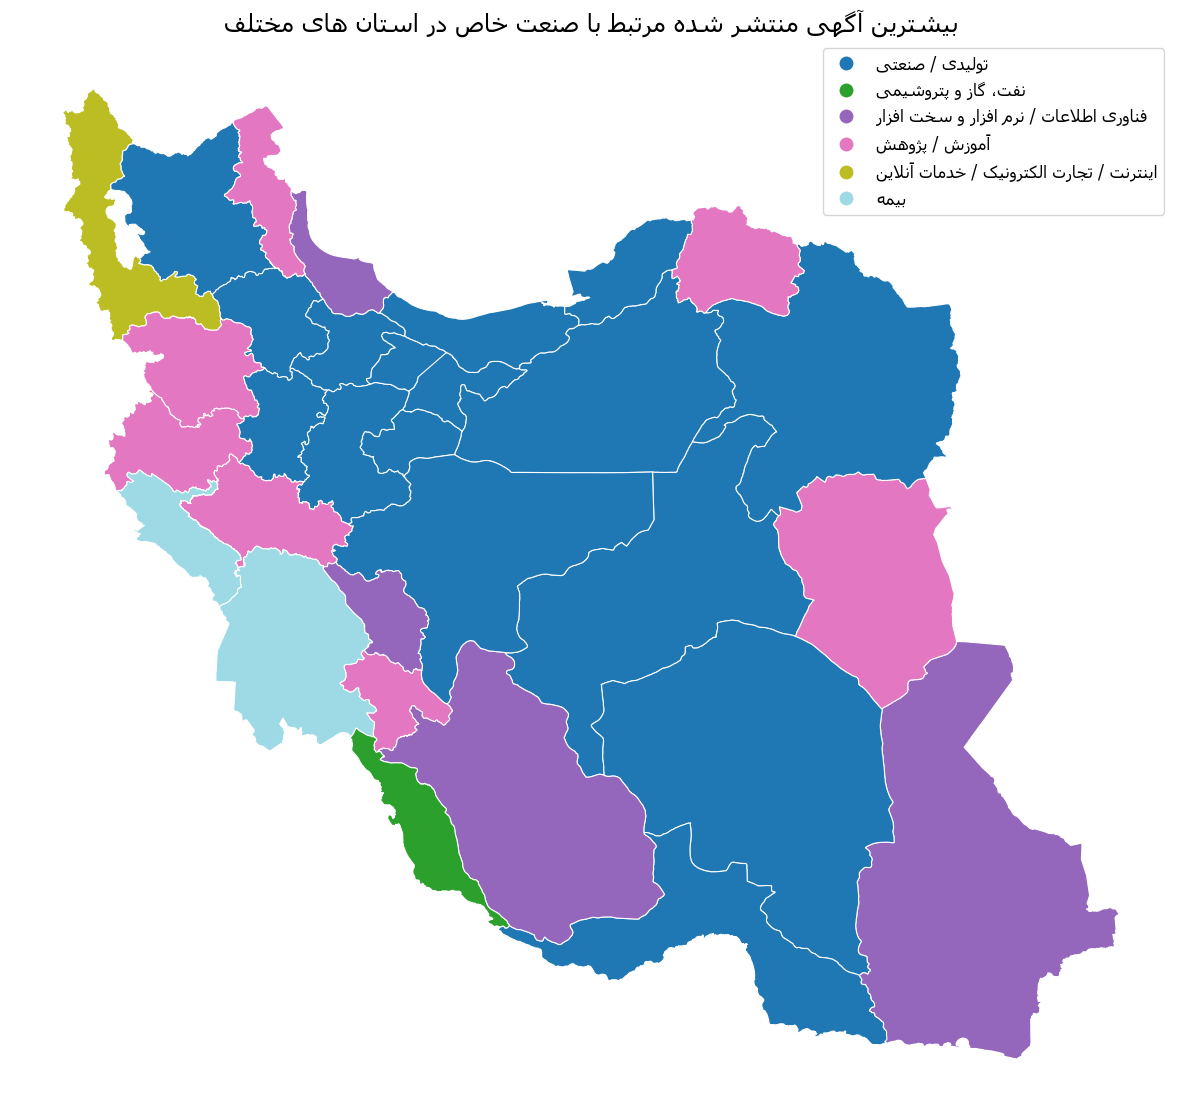

In [333]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged.plot(column='industry', ax=ax, legend=True, cmap='tab20', edgecolor='white', linewidth=0.8)


'''for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged.index):
    ax.text(x, y, get_display(reshape(label)), fontsize=8)'''


ax.set_title(get_display(reshape('بیشترین آگهی منتشر شده مرتبط با صنعت خاص در استان های مختلف')), fontsize=18)


ax.axis('off')


#plt.savefig('iran_industry_map.png', dpi=300)


plt.show()